### OMLDS End-to-End Machine Learning Project

##### Kaggle Credit Fraud Detection Dataset
##### Dataset Source: https://www.kaggle.com/datasets/kartik2112/fraud-detection

##### Date: 10/19/2023

#### Objective

The main objective in this notebook is creating an engineered feature, distance, based on the provided location data of the buyer and merchant.


#### Feature Engineering steps:

1.  Prior to feature engineering it is assumed you've gotten familier with the 
    data via EDA (exploratory data anaylsis)

2.  With latitude and longitude for buyer and merchant in the dataset, it was 
    reasonable to create a distance calculation.

3.  While creating this new feature, we evaluate it again with EDA techniques to
    determine if it is a usefule feature and if it leads us to additional 
    engineered features or different methods of calculation.



In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import os 
from haversine import haversine, Unit
from dython.nominal import (identify_nominal_columns, associations)

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 16)

### Read in training dataset

Use the next two blocks, if you are using your personal google drive use this code.  You need your google credentials.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# df_train = pd.read_csv(
#     '/content/drive/MyDrive/kaggle_credit_fraud_detection/fraudTrain.csv', 
#     index_col=0, 
#     parse_dates = ["trans_date_trans_time", "dob"]
# )

Or use local copy stored in ../data folder

In [2]:
df_train = pd.read_csv(
    '../data/fraudTrain.csv', 
    index_col=0, 
    parse_dates = ["trans_date_trans_time", "dob"]
)


In [3]:
# convert the unix_time to datetime
df_train["converted_unix_time"] = pd.to_datetime(df_train["unix_time"],unit='s')
# data type info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

### Distance feature calculation
We want to build an engineered feature, "distance".  For our example, we will use the haversine formula for shortest distance betwen two points on a sphere (globe) based on latitude and longitude.

Uses additional libraries:  
1. ```pip install haversine``` 
2. ```pip install dython```

In [ ]:
# use these installs if running in Google Colab
# # install haversine library
# !pip install haversine
# # install dython library
# !pip install dython

In [ ]:
from haversine import haversine, Unit

For ease of use in this example, make a copy of just the columns we need to calculate distances.


In [4]:
df_locs = df_train[["trans_num", "is_fraud", "cc_num","lat","long", "merch_lat","merch_long","street", "city","state","zip"]]
df_locs.rename(columns={"lat": "buyer_lat", "long":"buyer_long"}, inplace=True)

The haversine library for calculating distance takes tuples of latitude, longitude as input.
Create new columns for buyer and merchant locations.

In [5]:
df_locs["buyer_location"] = df_locs[["buyer_lat", "buyer_long"]].apply(tuple, axis=1)
df_locs["merchant_location"] = df_locs[["merch_lat", "merch_long"]].apply(tuple, axis=1)

In [6]:
df_locs.head()

,trans_num,is_fraud,cc_num,buyer_lat,buyer_long,merch_lat,merch_long,street,city,state,zip,buyer_location,merchant_location
0,0b242abb623afc578575680df30655b9,0,2703186189652095,36.0788,-81.1781,36.011293,-82.048315,561 Perry Cove,Moravian Falls,NC,28654,"(36.0788, -81.1781)","(36.011293, -82.048315)"
1,1f76529f8574734946361c461b024d99,0,630423337322,48.8878,-118.2105,49.159047,-118.186462,43039 Riley Greens Suite 393,Orient,WA,99160,"(48.8878, -118.2105)","(49.159047, -118.186462)"
2,a1a22d70485983eac12b5b88dad1cf95,0,38859492057661,42.1808,-112.2620,43.150704,-112.154481,594 White Dale Suite 530,Malad City,ID,83252,"(42.1808, -112.262)","(43.150704, -112.154481)"
3,6b849c168bdad6f867558c3793159a81,0,3534093764340240,46.2306,-112.1138,47.034331,-112.561071,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"(46.2306, -112.1138)","(47.034331, -112.561071)"
4,a41d7549acf90789359a9aa5346dcb46,0,375534208663984,38.4207,-79.4629,38.674999,-78.632459,408 Bradley Rest,Doe Hill,VA,24433,"(38.4207, -79.4629)","(38.674999, -78.632459)"


In [ ]:
df_locs.info()

Create a function to enabling the calculation on all the rows of our dataset

In [7]:
def calc_distance(loc1_col, loc2_col):
  """Calculates the haversine distance between two geopoints 
  (tuples of latitude, longitude) in miles, rounded to 2 decimals.
  """
  return round((haversine(loc1_col, loc2_col, unit=Unit.MILES)),2)

In [8]:
df_locs["distance_buyer_merch"] = df_locs.apply(
    lambda x: calc_distance(
        x["buyer_location"], 
        x["merchant_location"]
    ), 
    axis=1
)

In [9]:
df_locs.head()

,trans_num,is_fraud,cc_num,buyer_lat,buyer_long,merch_lat,merch_long,street,city,state,zip,buyer_location,merchant_location,distance_buyer_merch
0,0b242abb623afc578575680df30655b9,0,2703186189652095,36.0788,-81.1781,36.011293,-82.048315,561 Perry Cove,Moravian Falls,NC,28654,"(36.0788, -81.1781)","(36.011293, -82.048315)",48.84
1,1f76529f8574734946361c461b024d99,0,630423337322,48.8878,-118.2105,49.159047,-118.186462,43039 Riley Greens Suite 393,Orient,WA,99160,"(48.8878, -118.2105)","(49.159047, -118.186462)",18.77
2,a1a22d70485983eac12b5b88dad1cf95,0,38859492057661,42.1808,-112.2620,43.150704,-112.154481,594 White Dale Suite 530,Malad City,ID,83252,"(42.1808, -112.262)","(43.150704, -112.154481)",67.24
3,6b849c168bdad6f867558c3793159a81,0,3534093764340240,46.2306,-112.1138,47.034331,-112.561071,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"(46.2306, -112.1138)","(47.034331, -112.561071)",59.45
4,a41d7549acf90789359a9aa5346dcb46,0,375534208663984,38.4207,-79.4629,38.674999,-78.632459,408 Bradley Rest,Doe Hill,VA,24433,"(38.4207, -79.4629)","(38.674999, -78.632459)",48.19


array([[<Axes: title={'center': 'distance_buyer_merch'}>]], dtype=object)

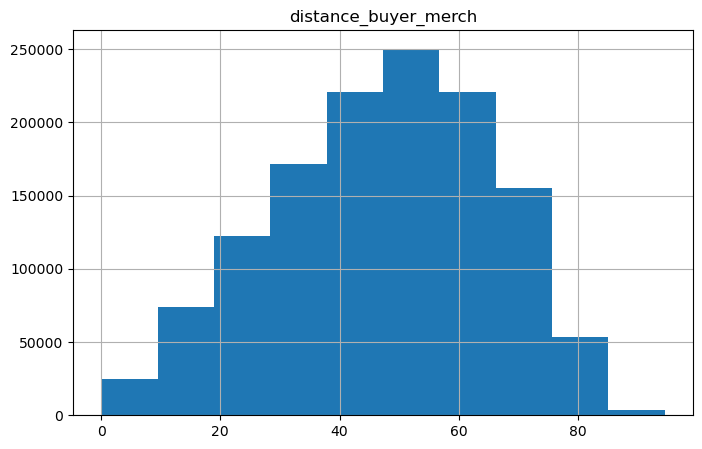

In [10]:
# look at the distance distribution
df_locs[["distance_buyer_merch"]].hist(figsize=(8,5))

Text(0.5, 1.0, 'Correlation Heatmap')

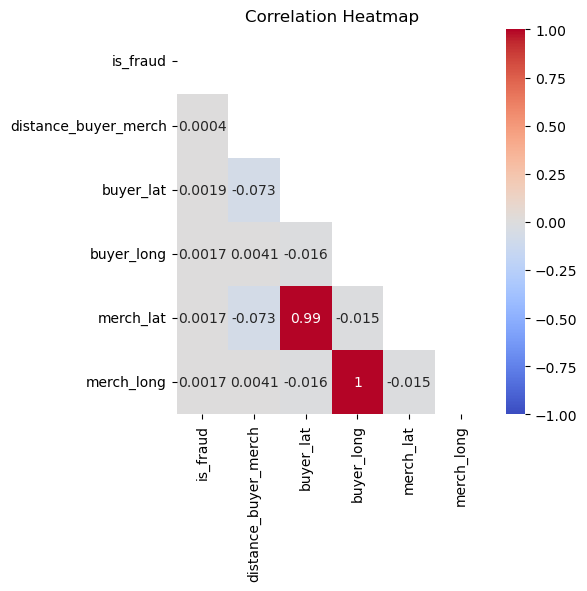

In [15]:

plt.rcParams['figure.figsize'] = (5, 5)

dist_corr = df_locs[
    [
        "is_fraud", 
        "distance_buyer_merch", 
        "buyer_lat", 
        "buyer_long",
        "merch_lat", 
        "merch_long",
    ]
].corr()
# mask diagonal and upper triangle
mask = np.triu(np.ones_like(dist_corr, dtype=bool))
heatmap = sns.heatmap(
    dist_corr, 
    vmin=-1.0, 
    vmax=1.0, 
    cmap="coolwarm",
    mask=mask,
    annot=True)
heatmap.set_title("Correlation Heatmap")

While the correlation of distance to fraud is not compeling as a feature, lets explore how we may have arrived at an engineered distance feature if we did not have lat & long in the dataset.

### Geocoding

Geocoding can be done at different levels (address, zip code, city, state).  The best would be at the specific buyer address and merchant location.  But this also has different meanings for online vs. in-person purchases.  This example is using city, state as the basis of geocoding for latitude and longitude.

We're using a geocoding guide by Peter Haas published [here](https://peterhaas-me.medium.com/how-to-geocode-with-python-and-pandas-4cd1d717d3f7) on Medium to geocode the 
addresses in our dataset.

You'll need to install the geopy library:   ```pip install geopy```

In [37]:
from geopy.geocoders import Nominatim               # OpenStreetMaps geocoding service
from geopy import distance                          # distance calculation built into geopy library
from geopy.extra.rate_limiter import RateLimiter    # To limit service request rates per provider terms (Nominatum is 1/sec)

Create instances of the geocoding classes that enable applying the service to a dataframe.  
We need to limit the API call rate to be compliant with the service terms.

In [38]:
geolocator = Nominatim(timeout=10, user_agent="OMLDS_test")
geocode = RateLimiter(
    geolocator.geocode, 
    min_delay_seconds=1, 
    max_retries=2, 
    error_wait_seconds=5.0, 
    swallow_exceptions=True,
    return_value_on_exception=None
    )

Since addresses are supposed to be unique per cc_num, we don't need to call geocoding on all transactions, only unique cc_num/address combinations.  This will greatly reduce the number of geocoding calls (983 instead of 1.2M+).

In [30]:
df_geocode = df_train[["cc_num", "street", "city", "state", "zip"]].copy()
df_geocode.drop_duplicates(inplace=True)
df_geocode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 1275589
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cc_num  983 non-null    int64 
 1   street  983 non-null    object
 2   city    983 non-null    object
 3   state   983 non-null    object
 4   zip     983 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 46.1+ KB


In the case of this simulated dataset the full address is not real.  Therefore we are using city, state to retrieve a geocode.

In [31]:
# add columns for city_state and full_address used in geocoding
# because this is a simulated public training dataset the full addresses are not real
# we can however use the city and state as an approximation of location aside from the given lat/long

# if we were using real data, we'd create a full address field to geocode
# df_cc_address["full_address"] = df_cc_address.street + "," + df_cc_address.city + "," + df_cc_address.state #+ ", " + str(df_cc_address.zip)

# This geocoding service requires city,state with no spaces
df_geocode["city_state"] = df_geocode.city +","+df_geocode.state


In [32]:
df_geocode.head()

,cc_num,street,city,state,zip,city_state
0,2703186189652095,561 Perry Cove,Moravian Falls,NC,28654,"Moravian Falls,NC"
1,630423337322,43039 Riley Greens Suite 393,Orient,WA,99160,"Orient,WA"
2,38859492057661,594 White Dale Suite 530,Malad City,ID,83252,"Malad City,ID"
3,3534093764340240,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"Boulder,MT"
4,375534208663984,408 Bradley Rest,Doe Hill,VA,24433,"Doe Hill,VA"


Running the free geocoding service offered by open streetmaps is limited to 1 call per second.  For the full set of unique city-states we need approx. 20 min.  We'll use a small test set to show how the call works.  The file full file is saved as geocode_city_state.csv

In [33]:
df_geocode_sample = df_geocode.sample(n=5, random_state=42)

In [34]:
df_geocode_sample

,cc_num,street,city,state,zip,city_state
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City,OK"
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda,MI"
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine,PA"
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty,NM"
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica,KS"


In [39]:
df_geocode_sample["geocode"] = df_geocode_sample["city_state"].apply(geocode)

In [40]:
df_geocode_sample

,cc_num,street,city,state,zip,city_state,geocode
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City,OK","(Oklahoma City, Oklahoma County, Oklahoma, Uni..."
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda,MI","(Baroda, Baroda Township, Berrien County, Mich..."
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine,PA","(Irvine, Brokenstraw Township, Warren County, ..."
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty,NM","(Moriarty, Torrance County, New Mexico, 87035,..."
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica,KS","(Utica, Ness County, Kansas, United States, (3..."


Extract the latitude and longitude info from the geocode object to new fields

In [41]:
df_geocode_sample["geocode_city_state_lat"] = [g.latitude for g in df_geocode_sample.geocode]
df_geocode_sample["geocode_city_state_long"] = [g.longitude for g in df_geocode_sample.geocode]

Create a tuple of lat,long for our distance calculation.

In [42]:
df_geocode_sample["geocode_location"] = df_geocode_sample[["geocode_city_state_lat", "geocode_city_state_long"]].apply(tuple, axis=1)

In [43]:
df_geocode_sample.head()

,cc_num,street,city,state,zip,city_state,geocode,geocode_city_state_lat,geocode_city_state_long,geocode_location
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City,OK","(Oklahoma City, Oklahoma County, Oklahoma, Uni...",35.472989,-97.517054,"(35.4729886, -97.5170536)"
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda,MI","(Baroda, Baroda Township, Berrien County, Mich...",41.957025,-86.484348,"(41.9570248, -86.4843483)"
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine,PA","(Irvine, Brokenstraw Township, Warren County, ...",41.839226,-79.268381,"(41.8392258, -79.2683812)"
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty,NM","(Moriarty, Torrance County, New Mexico, 87035,...",34.997204,-106.049488,"(34.9972037, -106.0494876)"
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica,KS","(Utica, Ness County, Kansas, United States, (3...",38.643903,-100.169852,"(38.6439032, -100.169852)"


In [ ]:
df_test = df_locs.merge(
    df_geocode[["city", "state", "geocode"]],
    on="city_state"
)

Reformat the city_state field for merging back to our main dataset.

In [ ]:
df_locs["distance_buyer_merch"] = df_locs.apply(
    lambda x: calc_distance(
        x["buyer_location"], 
        x["merchant_location"]
    ), 
    axis=1
)

In [ ]:
# FYI:  This took approx 20 min. to run
# df_geocode["geocode"] = df_geocode["city_state"].apply(geocode)

# save to pickle file
# df_geocode.to_pickle("../data/geocode_city_state.pkl")

# read saved pkl file
# df_geocode = pd.read_pickle("../data/geocode_city_state.pkl")

# df_geocode.info()

# df_geocode.loc[df_geocode["city"].str.startswith("Mc")]

### Geocoded city_state
Ricardo ran the set of city,state values through an R library and saved the lat, long info.

In [56]:
# retrieve geocode by city state
df_buyer_city_state = pd.read_csv('../data/new_home_coords.csv')
df_buyer_city_state.rename(
    columns={
        "address": "city_state", 
        "lat_home":"buyer_city_state_lat",
        "long_home":"buyer_city_state_long"},
    inplace=True
    )
df_buyer_city_state["buyer_city_state_location"] = df_buyer_city_state[
    ["buyer_city_state_lat", "buyer_city_state_long"]].apply(tuple, axis=1)
df_buyer_city_state.head()

,city_state,buyer_city_state_lat,buyer_city_state_long,buyer_city_state_location
0,"Medford, NY",40.817599,-73.000107,"(40.8175985, -73.0001068)"
1,"Norfolk, VA",36.844835,-76.286400,"(36.8448348, -76.2863999)"
2,"Oakton, VA",38.896729,-77.298697,"(38.896729, -77.29869697995693)"
3,"Moss Point, MS",30.411588,-88.534460,"(30.4115881, -88.5344601)"
4,"Freeport, ME",43.857307,-70.103760,"(43.857307, -70.10376)"


In [57]:
# add field for combining with city-state dataset
df_locs["city_state"] = df_locs["city"] +", " + df_locs["state"]

In [60]:
df_locs.head()

,trans_num,is_fraud,cc_num,buyer_lat,buyer_long,merch_lat,merch_long,street,city,state,zip,buyer_location,merchant_location,distance_buyer_merch,city_state,buyer_city_state_lat,buyer_city_state_long,buyer_city_state_location
0,0b242abb623afc578575680df30655b9,0,2703186189652095,36.0788,-81.1781,36.011293,-82.048315,561 Perry Cove,Moravian Falls,NC,28654,"(36.0788, -81.1781)","(36.011293, -82.048315)",48.84,"Moravian Falls, NC",36.102686,-81.181582,"(36.1026865, -81.18158238008564)"
1,1f76529f8574734946361c461b024d99,0,630423337322,48.8878,-118.2105,49.159047,-118.186462,43039 Riley Greens Suite 393,Orient,WA,99160,"(48.8878, -118.2105)","(49.159047, -118.186462)",18.77,"Orient, WA",41.203103,-94.416518,"(41.2031032, -94.4165181)"
2,a1a22d70485983eac12b5b88dad1cf95,0,38859492057661,42.1808,-112.2620,43.150704,-112.154481,594 White Dale Suite 530,Malad City,ID,83252,"(42.1808, -112.262)","(43.150704, -112.154481)",67.24,"Malad City, ID",42.191587,-112.250798,"(42.1915872, -112.250798)"
3,6b849c168bdad6f867558c3793159a81,0,3534093764340240,46.2306,-112.1138,47.034331,-112.561071,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"(46.2306, -112.1138)","(47.034331, -112.561071)",59.45,"Boulder, MT",46.236595,-112.120834,"(46.236595, -112.120834)"
4,a41d7549acf90789359a9aa5346dcb46,0,375534208663984,38.4207,-79.4629,38.674999,-78.632459,408 Bradley Rest,Doe Hill,VA,24433,"(38.4207, -79.4629)","(38.674999, -78.632459)",48.19,"Doe Hill, VA",38.387066,-79.520324,"(38.3870661, -79.5203237)"


In [59]:
# Merge in the city_state based location data
df_locs = pd.merge( 
    left=df_locs, 
    right=df_buyer_city_state,
    how="left",
    left_on="city_state",
    right_on="city_state")

In [62]:
# distance between buyer's city-state loc and merch loc
df_locs["distance_buyer_city_state_merch"] = df_locs.apply(
    lambda x: calc_distance(
        x["buyer_city_state_location"],
        x["merchant_location"]
    ), 
    axis=1
)

array([[<Axes: title={'center': 'distance_buyer_merch'}>,
        <Axes: title={'center': 'distance_buyer_city_state_merch'}>]],
      dtype=object)

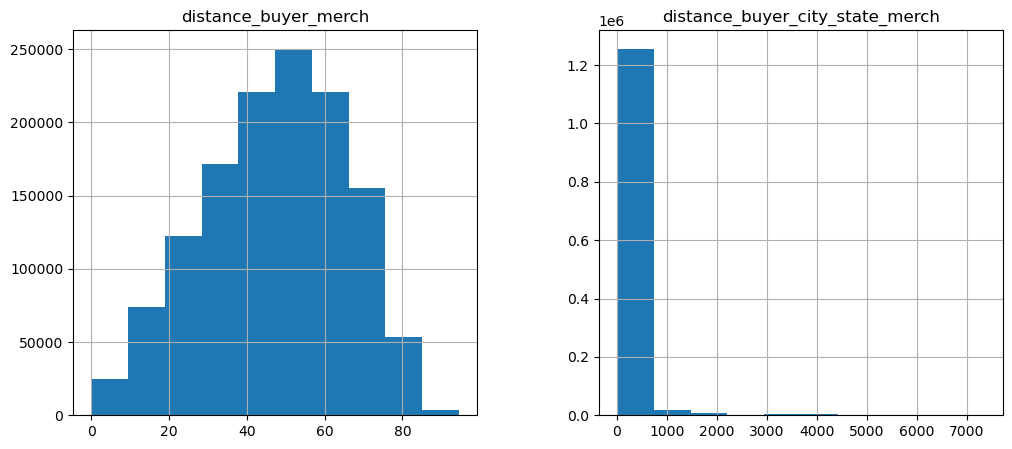

In [65]:
# histogram comparison
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
df_locs[["distance_buyer_merch", "distance_buyer_city_state_merch"]].hist(ax=ax)

Text(0.5, 1.0, 'Correlation Heatmap')

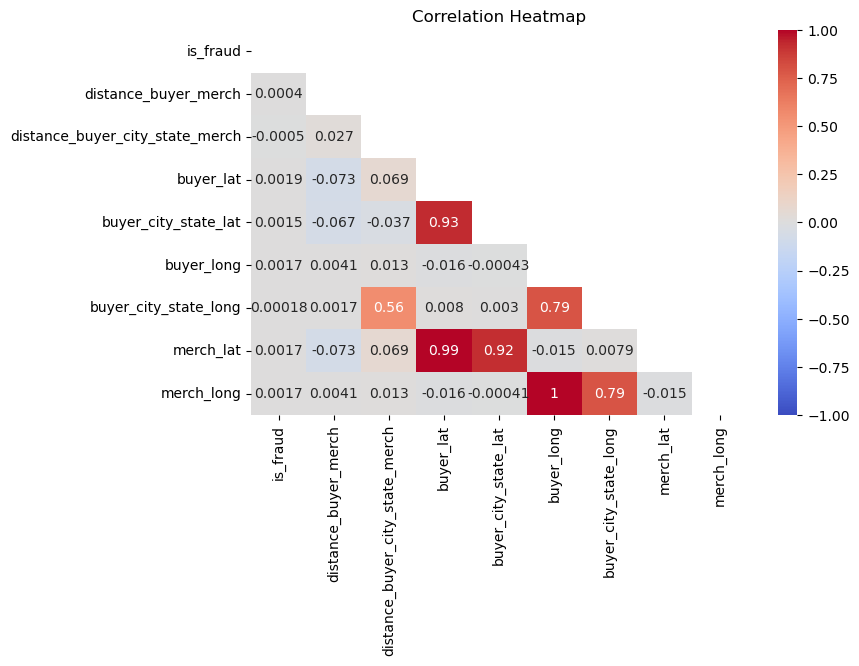

In [72]:
plt.rcParams['figure.figsize'] = (8, 5)

dist_corr = df_locs[
    [
        "is_fraud", 
        "distance_buyer_merch",
        "distance_buyer_city_state_merch", 
        "buyer_lat", 
        "buyer_city_state_lat",
        "buyer_long",
        "buyer_city_state_long",
        "merch_lat", 
        "merch_long",
    ]
].corr()
# mask diagonal and upper triangle
mask = np.triu(np.ones_like(dist_corr, dtype=bool))
heatmap = sns.heatmap(
    dist_corr, 
    vmin=-1.0, 
    vmax=1.0, 
    cmap="coolwarm",
    mask=mask,
    annot=True)
heatmap.set_title("Correlation Heatmap")

It doesn't look like our engineered distance feature is going to be a meaningful factor in determining fraud.

### Other things to consider


#### Alternate Geocoding Libraries
The [pgeocode](https://pypi.org/project/pgeocode/) is another library useful for geocoding.  In particular, you can use postal code as the basis of geocoding, as seen in the example below.

Commercially, the [Google Maps API](https://developers.google.com/maps) is an good mapping and geocoding option.  Possibility to add distance measured in time or driving distances instead of haversine distance.



In [47]:
import pgeocode
nomi = pgeocode.Nominatim(country="us")
nomi.query_postal_code("61335")

postal_code          61335
country_code            US
place_name         Mc Nabb
state_name        Illinois
state_code              IL
county_name         Putnam
county_code          155.0
community_name         NaN
community_code         NaN
latitude            41.173
longitude         -89.2187
accuracy               1.0
Name: 0, dtype: object

#### Binning
May be there is value in binning the distance as an engineered factor to see if there are groups of distances that are a meaningful factor in detecting fraud (i.e. > 100 miles may be more correlated than distance in general)  

In [ ]:
bins = [0,25,50,75,100]
bin_labels = [1,2,3,4]
df_locs["bin_dist_buyer_merch"] = pd.cut(df_locs["distance_buyer_merch"], bins=bins)
df_locs["bin_label_dist_buyer_merch"] = pd.cut(df_locs["distance_buyer_merch"], bins=bins, labels=bin_labels)

df_locs[["distance_buyer_merch","bin_dist_buyer_merch","bin_label_dist_buyer_merch"]].head()

df_locs["bin_label_dist_buyer_merch"] = df_locs["bin_label_dist_buyer_merch"].astype(int)

#### Libraries to evaluate categorical feature correlation
Libraries like dython allow for quick evaluation of categorical data in correlation matrix.  Review this [kaggle](https://www.kaggle.com/code/kagancatan/categorical-variables-correlation-using-dython) article for more info.

In [ ]:
from dython.nominal import (identify_nominal_columns, associations)

In [85]:
df_locs_w_catigoricals = df_locs.merge(
    df_train[["trans_num","category", "gender", "job"]],
    on="trans_num",
    how="inner"
)
df_locs_w_catigoricals.drop(
    columns=[
        "trans_num",
        "cc_num",
        "street",
        "buyer_location", 
        "merchant_location",
        "buyer_city_state_location",
        "city_state",
    ],
    inplace=True
)

In [ ]:
df_locs_w_catigoricals.info()

In [87]:
categorical_features=identify_nominal_columns(df_locs_w_catigoricals)
categorical_features

['city', 'state', 'category', 'gender', 'job']

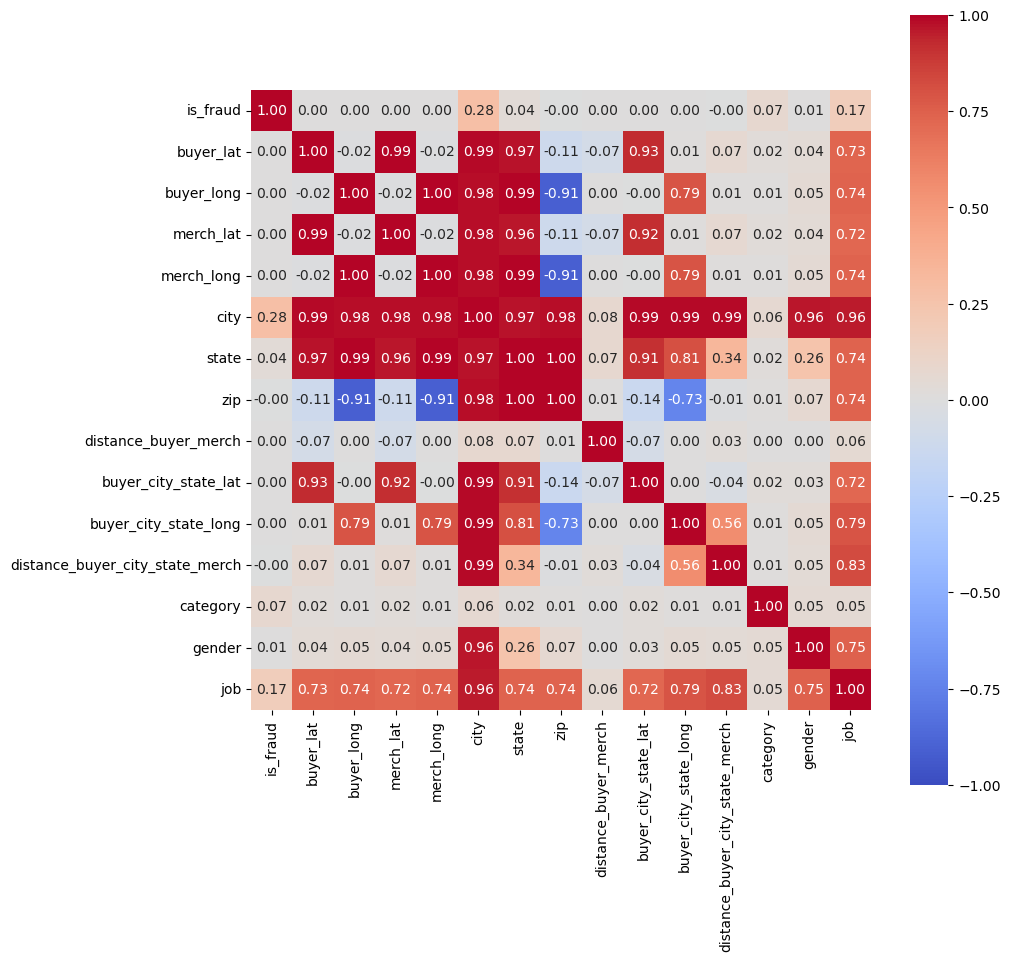

{'corr':                                  is_fraud  buyer_lat  buyer_long  merch_lat  \
 is_fraud                         1.000000   0.001894    0.001721   0.001741   
 buyer_lat                        0.001894   1.000000   -0.015533   0.993592   
 buyer_long                       0.001721  -0.015533    1.000000  -0.015452   
 merch_lat                        0.001741   0.993592   -0.015452   1.000000   
 merch_long                       0.001721  -0.015509    0.999120  -0.015431   
 city                             0.284260   0.985100    0.982884   0.978752   
 state                            0.037969   0.971118    0.993326   0.964924   
 zip                             -0.002162  -0.114290   -0.909732  -0.113561   
 distance_buyer_merch             0.000403  -0.072634    0.004058  -0.072662   
 buyer_city_state_lat             0.001484   0.926120   -0.000428   0.920194   
 buyer_city_state_long            0.000176   0.008000    0.793683   0.007928   
 distance_buyer_city_state_merch

In [88]:
associations(df_locs_w_catigoricals, cmap='coolwarm', vmax=1.0, vmin=-1.0, fmt='.2f', annot=True, figsize=(10,10))

#### Tests for normality (gaussian distribution)
The following examples are tests of normality.  This Medium [article](https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411) is a more in depth look at normality tests.  

In [66]:

import math
from scipy.stats import shapiro

stat, p = shapiro(df_locs["distance_buyer_merch"])
print(f"stat = {stat:.3%}, p-value = {p:.5f}")
if p > 0.05:
    print("Probably normal (Gaussian)")
else:
    print("Probably not normal (Gaussian)")

stat = 98.713%, p-value = 0.00000
Probably not normal (Gaussian)


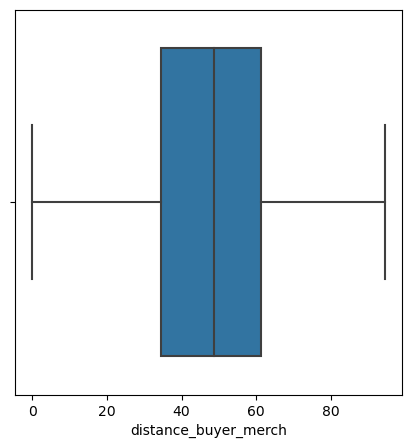

In [23]:
ax = sns.boxplot(x=df_locs["distance_buyer_merch"])


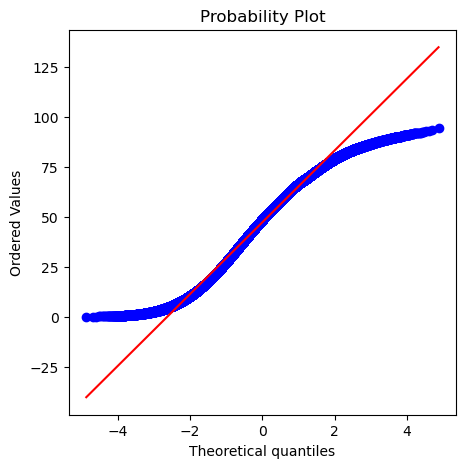

In [25]:

import scipy.stats as stats
import pylab

stats.probplot(df_locs["distance_buyer_merch"], dist="norm", plot=pylab)
pylab.show()